# introduce
[I made adjustments based on this](https://www.kaggle.com/code/koushikcon/dummy-submission)

**I design to use a mask image to record the mask data of each segmentation block and integrate the results of segmentation under different weights.
Although the final score is higher than both alone, its inference time changed from *a few minutes* to about *2 hours***


**Is there a better way to deduplicate when there are multiple models？**

<b><font size=5>I modified the previous idea to get the results of all the models before processing. The processing method is modified from overlapping direct discarding to deintersection, that is, accepting all results.With this method, I got a better score and the time changed from about<font color=red> 2 hours to 10 minutes</font><b>

<font color=red size=4>score: 0.264->0.285</font>

In [1]:
import sys
sys.path.append("/kaggle/input/yolov8/ultralytics-main")

In [2]:
import shutil
import os
import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

from pathlib import Path
from glob import glob
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import Image as show_image

import ultralytics
from ultralytics import YOLO

import torch

ultralytics.checks()

Ultralytics YOLOv8.0.120 🚀 Python-3.10.10 torch-2.0.0+cpu CPU
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 4813.6/8062.4 GB disk)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

IMAGE_SIZE = 512
BATCH_SIZE = 16
EPOCHS = 10

print(device)

cpu


In [4]:
import os
HOME = os.getcwd()
!mkdir /kaggle/working/packages
!cp -r /kaggle/input/pycocotools/* /kaggle/working/packages
os.chdir("/kaggle/working/packages/pycocotools-2.0.6/")
!python setup.py install
!pip install . --no-index --find-links /kaggle/working/packages/
os.chdir("/kaggle/working")

import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
from PIL import Image
import cv2
import pandas as pd
import os
from itertools import groupby
from skimage.measure import label, regionprops

def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != bool:
        raise ValueError(
            "encode_binary_mask expects a binary mask, received dtype == %s" %
            mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            "encode_binary_mask expects a 2d mask, received shape == %s" %
            mask.shape)

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str

running install
/opt/conda/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/setuptools/command/easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
reading manifest file 'pycocotools.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib.linux-x86_64-3.10
cre

# infer

In [5]:
# To determine if the current position has been detected
def count_change(old,new):
    sum=0
    for i in range(old.shape[0]):
        for j in range(old.shape[1]):
            if new[i,j] == True and old[i,j] == True:
                return True
    
    return False

In [6]:
# Draw mask image
def draw_mask(array):
    plt.figure()
    image_array = np.array(array)
    plt.imshow(image_array, cmap='binary')
    plt.axis('off')
    plt.show()

In [7]:
# Segment the picture and record the mask result
def make_mask(model,im1,row, mask_all):
    results = model.predict(source=im1)
    boxe_data = results[0].boxes.data.cpu().numpy()
    mask_data = results[0].masks.data
    row["width"] = results[0].orig_shape[0]
    row["height"] = results[0].orig_shape[1]

    mask_data = mask_data == 1# multiple images are expected
    mask_data = mask_data * 1
    mask_data = mask_data.cpu().numpy()

    mask_data = mask_data.astype(bool)
    prediction_l = []
    list_encode = []
    conf_encode = []
    
    
    
    for i in range(boxe_data.shape[0]):
        class_no = int(boxe_data[i][5])
        class_conf = boxe_data[i][4]
        class_conf = float(class_conf)
        
        if class_no !=0 :
            continue
            
        if count_change(mask_all,mask_data[i,:,:]):
            continue
        
        mask_all = mask_all | mask_data[i,:,:]
        
        sliceImage = mask_data[i,:,:]
        coded_len = encode_binary_mask(sliceImage).decode('utf-8')
                # if len(coded_len) < 90:
        list_encode.append(coded_len)
        conf_encode.append(class_conf)
    
    
    for i in range(len(conf_encode)):
        row["prediction_string"] += '0 ' + str(conf_encode[i])+' '+ list_encode[i]+' '
    
    return mask_all

# New approach

In [8]:
#Identify overlaps
def replace(mask_data,new_mask,num_mask):
    for i in range(num_mask):
        array = new_mask & mask_data[i,:,:]
        count = np.any(array == 1)
        if count > 0:
            return i
    return -1

In [9]:
# Get the mask union
def remask(old_mask,new_mask):
    return old_mask | new_mask

In [10]:
def get_result(results):
    mask_data = results[0].masks.data
    mask_data = mask_data == 1# multiple images are expected
    mask_data = mask_data * 1
    mask_data = mask_data.cpu().numpy()
    mask_data = mask_data.astype(bool)
    return mask_data

In [11]:
def get_change(boxe_data1,mask_data,mask_data1,num_mask,conf):
    for i in range(boxe_data1.shape[0]):
        change = replace(mask_data,mask_data1[i,:,:],num_mask)
        if change >= 0 :
            mask_data[change,:,:] = remask(mask_data[change,:,:],mask_data1[i,:,:])
        else:
            mask_data = np.concatenate((mask_data,np.expand_dims(mask_data1[i,:,:], axis=0)), axis=0)
            conf = np.concatenate((conf,np.expand_dims(float(boxe_data1[i][4]),axis=0)),axis=0)
            num_mask+=1
    return num_mask,mask_data,conf

In [12]:
def new_mask(model,model1,im):
    results = model.predict(source=im1)
    results1 = model1.predict(source=im1)
    
    mask_data = get_result(results)
    mask_data1 = get_result(results1)
    
    first_rs = results[0].boxes.data.cpu().numpy().shape[0]
    num_mask = first_rs
    
    boxe_data = results[0].boxes.data.cpu().numpy()
    boxe_data1 = results1[0].boxes.data.cpu().numpy()
    
    conf = np.empty(first_rs)
    for i in range(first_rs):
        class_conf = boxe_data[i][4]
        class_conf = float(class_conf)
        conf[i] = class_conf
    num_mask,mask_data,conf=get_change(boxe_data1,mask_data,mask_data1,num_mask,conf)
    
    return mask_data,num_mask,conf

In [13]:
model = YOLO("/kaggle/input/yolov8/120best.pt")
model1 = YOLO("/kaggle/input/yolov8/30best.pt")

all_rows = []
results_csv = pd.DataFrame([], columns=["id","height","width","prediction_string"])
results_csv.set_index("id")

for dirname, _, filenames in os.walk('/kaggle/input/hubmap-hacking-the-human-vasculature/test'):
    for filename in filenames:
        
        im1 = Image.open(os.path.join(dirname, filename))
        width, height = im1.size
        
        row = dict()
        row["id"] = filename[:-4]
        row["height"] = height
        row["width"] = width
        row["prediction_string"] = ""
        try:
            mask,num,conf = new_mask(model,model1,im1)
            for i in range(num):
                sliceImage = mask[i,:,:]
                coded_len = encode_binary_mask(sliceImage).decode('utf-8')
                row["prediction_string"] += '0 ' + str(conf[i])+' '+ coded_len+' '
        except:
            print("failed to some reason")
        
        new_row = pd.DataFrame(row, index=[0])
        results_csv = pd.concat([new_row, results_csv.loc[:]]).reset_index(drop=True)

results_csv.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [14]:
!cat submission.csv

id,height,width,prediction_string
72e40acccadf,512,512,0 0.8259779214859009 eNqLjggytU6yN/c29IdBAwMgNjSA8AyQaAMDGAlSgQNAZGDyuNURBlCr0BwCYfkZ+Rv5gXhGfsY+xr5GfqbeQRExhgAMESyf 0 0.7998782396316528 eNoLjM8xyTYIsTf1MSAHGPojWCA2BBv5QfjIYjARhEoINPKLCAgxAgCq5x2e 0 0.7457514405250549 eNrLjUsys0u0N/Yz9IdAAwMYC8bDgg0MgKSRP5IQjIWARhAjfY39jPwN/QwNgBgoZuQXH5BkAACj2Rxz 0 0.7207280993461609 eNotjtsKwkAMRH8pSVsQZBW2CILdpKK1tRdEq9UtXv7/zWz1YTjDzEDyyXP0UCyTjFzsIiZVnMUZMXGyma9m6+BQggCC4I/Wjbaj0vTOKytzVp6oNYI1D3aA2tRyt1dlIw/bw9G04u0FKtPJqCw1f2pf6O41sZI8vcHOHGSbetgvOGJkBGQSpWC4KxTeCIn6KdMFCOBvoT033Tv5AgG1OsQ= 0 0.6939664483070374 eNqLjMsytou3N/M29jfwNzA0MDDwBxGGfob+Rn6GIBqIjfyBIv6GGCQEowCwbjADYoihn7Gfka8RyBAI9DdEYD9jXyO/yKAwYwAyER82 0 0.6071067452430725 eNqLC48zTzcItzfxM/A3hEIDIACS/oYGYGwAEYEKGvkb+hr7mPga+xv6Gfka+xn5GfsZgsSASsM9AQgJEyo= 0 0.6057500839233398 eNqLDcoySzKItTf2M/QHQQMDCAaRIACjQcDfEE4b+oGwEQj6mnnE56YaAACGqRFM 0 0.568560779094696 eNqLi4kys0i3N/c09THyM/QHQgMDfzDtb2BgaOBvAKJBAMQ2APEgAiBlEHkwhjAQ6kE

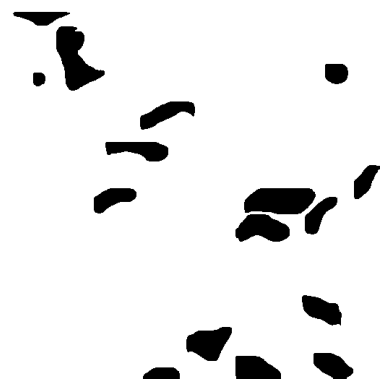

In [15]:
mask_all = np.zeros((512,512),dtype=bool)
for i in range(num):
#     print(i)
#     draw_mask(mask[i,:,:])
    mask_all |= mask[i,:,:]
draw_mask(mask_all)